# 패키지 설치하기


의존성 있는 패키지를 설치: 자연어 처리 실습을 위한 패키지 (https://github.com/ratsgo/ratsnlp)

In [1]:
!pip install ratsnlp

     |████████████████████████████████| 42 kB 543 kB/s 
     |████████████████████████████████| 8.0 MB 1.6 MB/s 
     |████████████████████████████████| 398 kB 42.9 MB/s 
     |████████████████████████████████| 2.8 MB 36.6 MB/s 
     |████████████████████████████████| 806 kB 42.7 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 136 kB 43.6 MB/s 
     |████████████████████████████████| 636 kB 43.5 MB/s 
     |████████████████████████████████| 829 kB 44.4 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x320e000 @  0x7fd2e2ca4615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
     |██████████

# 구글 드라이브 연동하기
모델 체크포인트 등을 저장해 둘 구글 드라이브를 연결합니다. 자신의 구글 계정에 적용됩니다.

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 각종 설정
모델 하이퍼파라메터(hyperparameter)와 저장 위치 등 설정 정보를 선언합니다.

In [3]:
#모델 환경 설정
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments #ratsnlp에서 classification을 위한 argument들 불러옴
args = ClassificationTrainArguments(
    pretrained_model_name="beomi/kcbert-base", #pretain을 마친 kcbert-base 모델 활용
    downstream_corpus_name="nsmc", #downstream taks에 사용할 데이터 
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls", #모델 저장 경로
    batch_size=32 if torch.cuda.is_available() else 4,
    learning_rate=5e-5, #배치 크기 
    max_seq_length=128, #토큰 기준 입력 문장의 최대 길이 
    epochs=3,
    tpu_cores=0 if torch.cuda.is_available() else 8,
    seed=7,
)

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


토큰 기준 입력 문장의 최대 길이 지정 이유 <br>
- AI는 길이가 같은 문장에 대하여 병렬 처리 가능함. 따라서 문장의 길이를 동일하게 맞춰줄 필요가 있음. 
- 너무 긴 문장은 최대 길이를 넘어가면 잘라주고, 짧은 문장은 [PAD] 라는 special token으로 자리를 채워 길이를 맞춰줌.

# 랜덤 시드 고정
학습 재현을 위해 랜덤 시드를 고정합니다.

In [4]:
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


# 로거 설정
메세지 출력 등을 위한 logger를 설정합니다.

In [5]:
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/My Drive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_size=32, cpu_workers=2, fp16=False, tpu_cores=0)


# 말뭉치 다운로드
실습에 사용할 말뭉치(Naver Sentiment Movie review Corpus)를 다운로드: NSMC Data

In [6]:
from Korpora import Korpora #데이터 내려받는 모듈 (https://github.com/ko-nlp/Korpora)
Korpora.fetch(
    corpus_name=args.downstream_corpus_name,
    root_dir=args.downstream_corpus_root_dir,
    force_download=True,
)

[nsmc] download ratings_train.txt: 14.6MB [00:00, 22.0MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 34.2MB/s]                           


# 토크나이저 준비
토큰화를 수행하는 토크나이저를 선언: 문장을 token들의 모음으로 분절하는 과정

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

# train data 구축
- torch에서는 Dataset과 DataLoader라는 기능을 통해 미니 배치 학습이나 데이터 셔플, 병렬 처리등을 간단하게 할 수 있음
- train data를 배치 딘위로 모델에 공급해주기 위해 DataLoader에서는 Dataset에 있는 요소들을 배치 크기만큼 뽑아 정해진 형식에 맞춰 배치를 만들어줌. 
- 상황에 맞게 배치 단위의 데이터를 뽑아 사용하므로 연산량을 줄일 수 있음. 

In [8]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset
corpus = NsmcCorpus()
##ClassificationDataset
#데이터와 tokenizer 포함 
#NsmcCorpus가 넘겨준 문장과 Label을 토큰화하여 모델이 학습할 수 있는 형태로 변환
train_dataset = ClassificationDataset( 
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="train",
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    sampler=RandomSampler(train_dataset, replacement=False), #샘플링 방식: 비복원 랜덤 추출
    collate_fn=nlpbook.data_collator, #배치로 만드는 역할하는 함수 
    drop_last=False,
    num_workers=args.cpu_workers,
)

INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 44.581 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 아 더빙.. 진짜 짜증나네요 목소리
INFO:ratsnlp:tokens: [CLS] 아 더 ##빙 . . 진짜 짜증나네 ##요 목소리 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

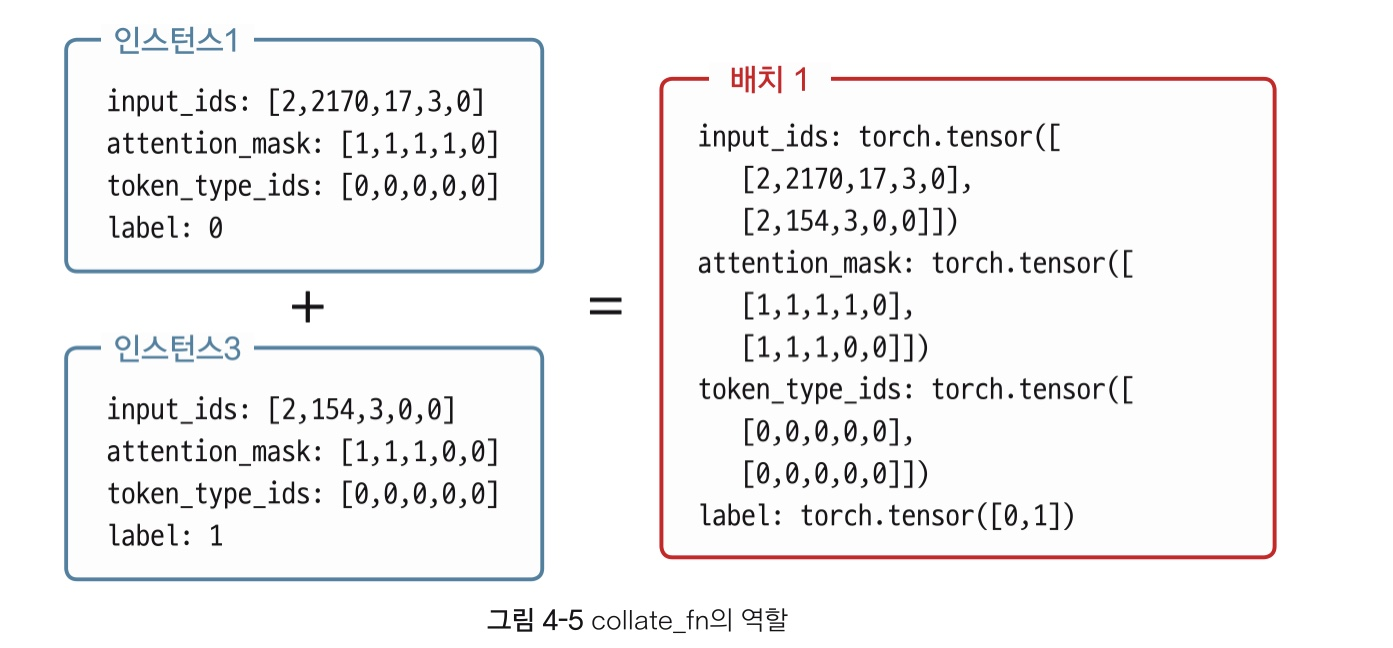

# 테스트 데이터 구축
학습 중에 평가할 테스트 데이터를 구축합니다.

In [9]:
val_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="test",
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    sampler=SequentialSampler(val_dataset), #validation 시에는 data 전체를 다 사용하기 때문에 굳이 random하게 해줄 필요 없음. 
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)


INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 14.269 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 굳 ㅋ
INFO:ratsnlp:tokens: [CLS] 굳 ㅋ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

# 모델 초기화
프리트레인이 완료된 BERT 모델을 읽고, 문서 분류를 수행할 모델을 초기화합니다.

In [10]:
from transformers import BertConfig, BertForSequenceClassification
#모델 초기화
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name, #kcbert-base o/)
    num_labels=corpus.num_labels,
)

pretrained_model_name 부분을 바꿔 hugging face에 등록된 Pretrain model 불러와 자유롭게 사용가능 (https://huggingface.c

In [11]:
model = BertForSequenceClassification.from_pretrained( #문서 분류용 task module 더해진 클래스 (행렬 곱한 후 softmax)
        args.pretrained_model_name,
        config=pretrained_model_config,
)

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

# 학습 준비
Task와 Trainer를 준비합니다.

In [12]:
from ratsnlp.nlpbook.classification import ClassificationTask
#task 정의
task = ClassificationTask(model, args)

- Optimizer: Adam
- lr scheduler: ExponentialLR (이전 epoch's lr * gamma(0.9) )

In [13]:
#GPU 설정, 로그 및 체크포인트 등 다양한 설정 자동으로 가능
trainer = nlpbook.get_trainer(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


# 학습
준비한 데이터와 모델로 학습을 시작합니다. 학습 결과물(체크포인트)은 미리 연동해둔 구글 드라이브의 준비된 위치(`/gdrive/My Drive/nlpbook/checkpoint-doccls`)에 저장됩니다.

In [ ]:
trainer.fit( 
    task,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 108 M 
--------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.680   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# 각종 설정
모델 하이퍼파라메터(hyperparameter)와 저장 위치 등 설정 정보를 선언합니다.

In [ ]:
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls", #fintuing한 모델의 체크 포인트 
    max_seq_length=128, #default
)

# 모델 로딩
파인튜닝을 마친 모델과 토크나이저를 읽어 들입니다.

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification
#fintuing한 모델의 체크 포인트 
fine_tuned_model_ckpt = torch.load(
    args.downstream_model_checkpoint_fpath,
    map_location=torch.device("cpu")
)
#모델의 설정값들 불러오기
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel(),
)
#설정값대로 모델 초기화 
model = BertForSequenceClassification(pretrained_model_config)
#체크 포인트 주입
model.load_state_dict({k.replace("model.", ""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})
#모델 평가 모드로 전환: dropout 등의 train 시에만 사용되는 기법들 무효화시킴
model.eval()

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

# 인퍼런스 함수 선언
인퍼런스 함수를 선언합니다.

In [ ]:
def inference_fn(sentence):
    inputs = tokenizer(
        [sentence],
        max_length=args.max_seq_length,
        padding="max_length",
        truncation=True,
    )
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})
        prob = outputs.logits.softmax(dim=1)
        #softmax 결과를 소수점 4자리로 반올림
        positive_prob = round(prob[0][1].item(), 4)
        negative_prob = round(prob[0][0].item(), 4)
        #예측 확률의 최대값 위치에 따라 결과 만들기 
        pred = "긍정 (positive)" if torch.argmax(prob) == 1 else "부정 (negative)"
    return {
        'sentence': sentence,
        'prediction': pred,
        'positive_data': f"긍정 {positive_prob}",
        'negative_data': f"부정 {negative_prob}",
        'positive_width': f"{positive_prob * 100}%",
        'negative_width': f"{negative_prob * 100}%",
    }

# 웹서비스 만들기 준비

`ngrok`은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구입니다. `ngrok`을 실행하려면 [회원가입](https://dashboard.ngrok.com/signup) 후 [로그인](https://dashboard.ngrok.com/login)을 한 뒤 [이곳](https://dashboard.ngrok.com/get-started/your-authtoken)에 접속해 인증 토큰(authtoken)을 확인해야 합니다. 예를 들어 확인된 `authtoken`이 `test111`이라면 다음과 같이 실행합니다.

```bash
!mkdir /root/.ngrok2 && echo "authtoken: test111" > /root/.ngrok2/ngrok.yml
```

In [ ]:
!mkdir /root/.ngrok2 && echo "authtoken: {이곳에 확인된 인증 토큰을 입력하세요}" > /root/.ngrok2/ngrok.yml

# 웹서비스 개시
아래처럼 실행해 인퍼런스 함수를 웹서비스로 만듭니다.

In [ ]:
from ratsnlp.nlpbook.classification import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()